<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Partie_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are men and women politician speaking the same language ? 

This projects aims at building a gender classifier for text from a corpus of French political speeches 

We use for that purpose a NLP toolbox and we proceed in three different steps. 


1.   Explore the corpus and extract relevant features
2.   Create a baseline model
3.   Compare the baseline model with a CamemBERT 



## Part I : Corpus analysis

### Downloading packages

In [0]:
!python -m spacy download fr_core_news_md
import nltk
nltk.download('punkt')

In [2]:
import spacy
from funct import *
import nltk
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import add
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from os import path
from PIL import Image
import funct
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
nlp = spacy.load('fr_core_news_md') 
import multiprocessing as mp
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from sklearn import utils
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    scorer)
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


We import our corpus in the notebook. 
This corpus has been scrapped from : https://www.vie-publique.fr/discours.
Because of the very large size of the corpus, we decide to only use 'déclarations' and 'discours' (interviews are deleted). 

In this part, we are using first our full dataset to make some basics statistical analysis then because our functions take to many time to compute we are forced to calculate it on smaller dataset. 

That's why we decide to select two subdataframe from this large one. Both have a shape of 5000 documents but one respect the repartition of male/female of our full corpus and the other is a balanced dataset with 2500/2500.


In this part we will first do some analyse (on the full dataset for the variable we already have and then on a sample dataset which respect the proportion of gender) and  then extract features (on both small dataset) which seems to be important to discriminize women and men (based on literature borrowed from psychology and language analysis).

In [3]:
df = pd.read_csv('fullDF.csv')
df.head()

,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte,Lien,sexe
0,13,273623,"Déclaration de M. Franck Riester, ministre de ...",déclaration,Société,Franck,Riester,Ministre de la culture,2020-02-26T12:00:00Z,"Culture - Médias,Média","Merci monsieur le président, cher Bruno Studer...",https://www.vie-publique.fr/discours/273623-fr...,1.0
1,17,273677,"Déclaration de Mme Amélie de Montchalin, secré...",déclaration,International,Amélie,de Montchalin,Secrétaire d'État aux affaires européennes,2020-02-26T12:00:00Z,"Union européenne,Politique agricole commune","Merci Monsieur le Président, Monsieur le Séna...",https://www.vie-publique.fr/discours/273677-am...,2.0
2,18,273741,"Déclaration de M. Edouard Philippe, Premier mi...",déclaration,Société,Edouard,Philippe,Premier ministre,2020-02-27T12:00:00Z,"Santé - Protection sociale,Santé publique,Maladie","Avec Olivier Veran, le ministre des Solidarité...",https://www.vie-publique.fr/discours/273741-ed...,1.0
3,19,273742,"Déclaration de M. Edouard Philippe, Premier mi...",déclaration,Société,Edouard,Philippe,Premier ministre,2020-02-27T12:00:00Z,"Education - Recherche,Politique de la recherche",Monsieur le directeur général de l'Institut Pa...,https://www.vie-publique.fr/discours/273742-ed...,1.0
4,20,273663,"Déclaration de M. Christophe Castaner, ministr...",déclaration,Société,Christophe,Castaner,Ministre de l'intérieur,2020-02-26T12:00:00Z,"Société - Population,Politique de l'immigration","Monsieur le Sénateur, Permettez-moi, avant d'...",https://www.vie-publique.fr/discours/273663-ch...,1.0


### Some basic external statistics

We clean the encoding of the text as a first treatment. 

In [0]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80',''))
df.Texte = df.Texte.apply(remove_source)

In [5]:
print('On average, text length is {}'.format(round(df.Texte.apply(len).mean())))

On average, text length is 11799


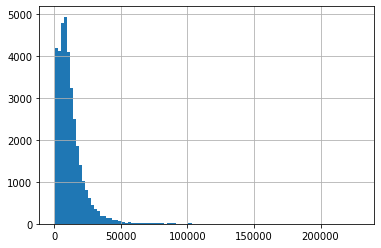

In [6]:
%matplotlib inline
df.Texte.apply(len).hist(bins=100)
plt.show()

#### Speakers gender proportions

In [7]:
print('The corpus gathers {} political speeches' .format(len(df)))
print('There are {} male speakers and {} female speakers'.format(df.sexe.map(str).value_counts()[0],df.sexe.map(str).value_counts()[1]))

The corpus gathers 35972 political speeches
There are 27059 male speakers and 8913 female speakers


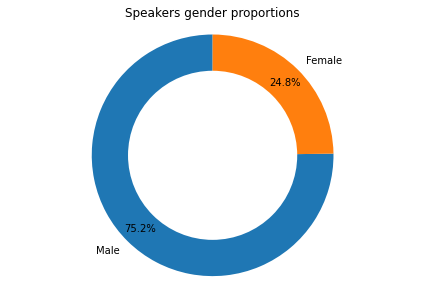

In [8]:
labels = ['Male','Female']
#colors = ['#ffcc99','#ff9999']
sizes = [ len(df[df.sexe ==1]),len(df[df.sexe ==2])]
fig, ax1 = plt.subplots()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Speakers gender proportions")
plt.show()

Without surprise we have an unbalanced corpus with men being much more represented than women.

#### Speakers gender through time 

Let's see how the proportion of women and men in the corpus changed through years. 

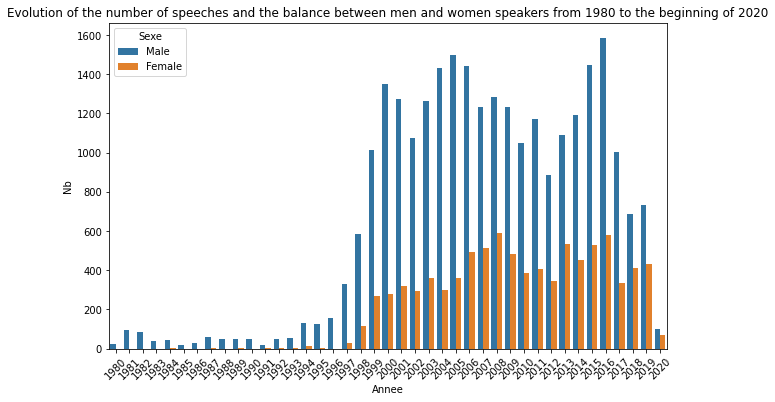

In [10]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Male'
        else:
            sexe='Female'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])
data=data[data['Annee']>='1980']
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution of the number of speeches and the balance between men and women speakers from 1980 to the beginning of 2020")
plt.show()

We definitely see an increase in the absolute number of female speakers. However the gap is still important. 
In the last three years we see that eventually the number of male and female speakers are really becoming closer. 

####  Speaker's gender and speeches general theme

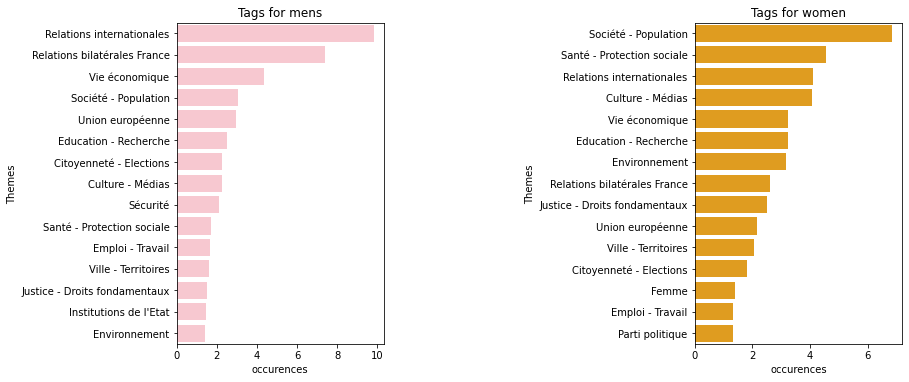

In [14]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
d = pd.concat([d_f,d_m])
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 0.5) & (d.Themes.apply(len) >0) & (d.sexe == 'Male')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color='pink')
plt.title("Tags for mens")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 0.6) & (d.Themes.apply(len) >0) & (d.sexe == 'Female')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color = 'orange')
plt.title("Tags for women")
plt.subplots_adjust(wspace = 1.5)

Men and women are not talking about the same subjects. If women are more likely to speak about Society and Health, men are more likely to speak about international relations and economics. 

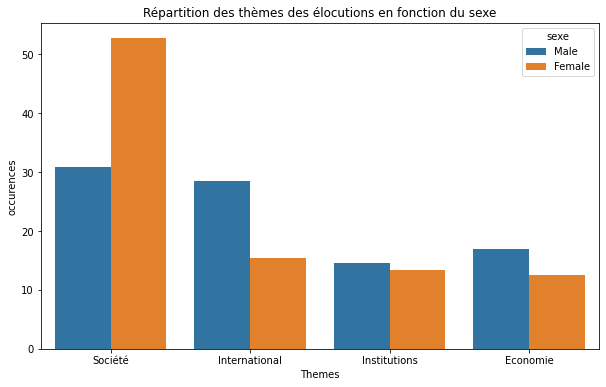

In [13]:
df.Theme.fillna('',inplace=True)
arr =df[df.sexe == 1].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
arr =df[df.sexe == 2].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
d = pd.concat([d_m,d_f])
plt.figure(figsize=(10,6))
sns.barplot(data = d[d.Themes != ''],hue = 'sexe',x='Themes',y='occurences')
plt.title('Répartition des thèmes des élocutions en fonction du sexe')
plt.xticks(rotation=0)
plt.show()

We represent the same chart but with a lower level of granularity in themes. The same conclustion can be drawn. And we clearly see that women are mostly speaking about society topics.

After this brief introduction we will dive into our texts. The next section focuses on cleaning and preprocessing our texts. We will try to construct some quantitative metrics that could be , in our opinion, explanatory features to differenciate female and male speakers. 


### Word-level preprocessing

Let's try different tokenizers ! 

We will now word on the reduced dataset. We will here present the result of the statistical analysis for the umbalanced dataset.

Choose one to compute (take hours for some function).

In [0]:
tokenizer = Tokenizer(nlp.vocab)
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

In [0]:
#df = pd.read_csv('medium_df_eq.csv')
#OR 
df = pd.read_csv('medium_df_deseq.csv')

In [0]:
print(len([w for w in tokenizer(df.Texte[0])]))

1702


In [0]:
([w for w in tokenizer(df.Texte[0])])[0:10]

[Messieurs,Je, suis, heureux, de, vous, saluer., Quand, je, dis, que]

In [0]:
print(len(word_tokenize(df.Texte[0], language='french')))

1932


In [0]:
word_tokenize(df.Texte[0], language='french')[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [0]:
print(len(toknizer.tokenize(df.Texte[0])))

2135


In [0]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [0]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

The NLTK tokenizer tokenizes punctuation whereas the spacy one does not. We decide to switch to the NLTK tokenizer.

In [0]:
print('Length of spacy stopwords list is {} and length of NLTK stopwords list is {} '.format(len(list(fr_stop)),len(stopwords.words('french'))))

Length of spacy stopwords list is 602 and length of NLTK stopwords list is 157 


In [0]:
As the NLTK sent detector is far from being optimal we tried to detect sentences with the 'sent_detector_mano' function which seems to work much better on our corpus.

We also added a way to clean the 
politeness formulation like 'Madame' or 'Monsieur' because they always occur at the beggining of our document.

In [0]:
df['NbToken'] = df.Texte.apply(lambda x : len(word_tokenize(x,language='french')))
df['Token'] = df.Texte.apply(lambda x : word_tokenize(x,language='french'))

In [0]:
lst_nom = [nom for nom in set(df.Nom+ ' ' +df.Prenom) if nom not in 'ministère'] + [nom for nom in set(df.Prenom+ ' ' +df.Nom) if nom not in 'ministère']+ [nom for nom in set(df.Prenom) if nom != 'ministère'] + [nom for nom in set(df.Nom) if nom != 'ministère']
cleanFast = lst_nom + ['Mr','M','Mme','Madame','Monsieur','monsieur','madame','mme','mr','mesdames','messieurs']

We are trying now with the help of Spacy (fr_core_news_md) to extract the POS Tagging in order to quantify the grammatical structure of our text. Unfortunately, the POS tagging extraction is **very slow**. 

In [0]:
df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
 

In [0]:
df['NbMot'] = df.Texte.apply(extraire_nb_mot)
df['PronJe']=df.apply(lambda row : Pron_Type(row.Texte,nlp),axis=1)
df['PronNous']=df.apply(lambda row : Pron_Type_Plur(row.Texte,nlp),axis=1)
df['NbPres'],df['NbPast'],df['NbFut'],df['NbImp']  = zip(*df.apply(lambda row : Verb_Tens(row.Texte,nlp),axis=1))
df['NbQuest']= df.apply(lambda row : Quest(row.Texte,nlp),axis=1)
df['NbExcl']= df.apply(lambda row  : Excl(row.Texte,nlp),axis=1)
df['NbArt']= df.Texte.apply(nbArt)
df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)
df['CleanToken'] = df.Texte.apply(cleanToken)
df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))

Now we calculating Hapaxlegomena it is the number of words which appear only once while Hapaxdislegomena is the number of words which appear twice. 

We are also calculating the F_mesure ([source](https://www.cs.uic.edu/~liub/publications/EMNLP-2010-blog-gender.pdf)) which is based on the frequency of the POS usage in a text and explores the notion of implicitness
of text and is a unitary measure of text’s relative
contextuality (implicitness), as opposed to its
formality (explicitness).

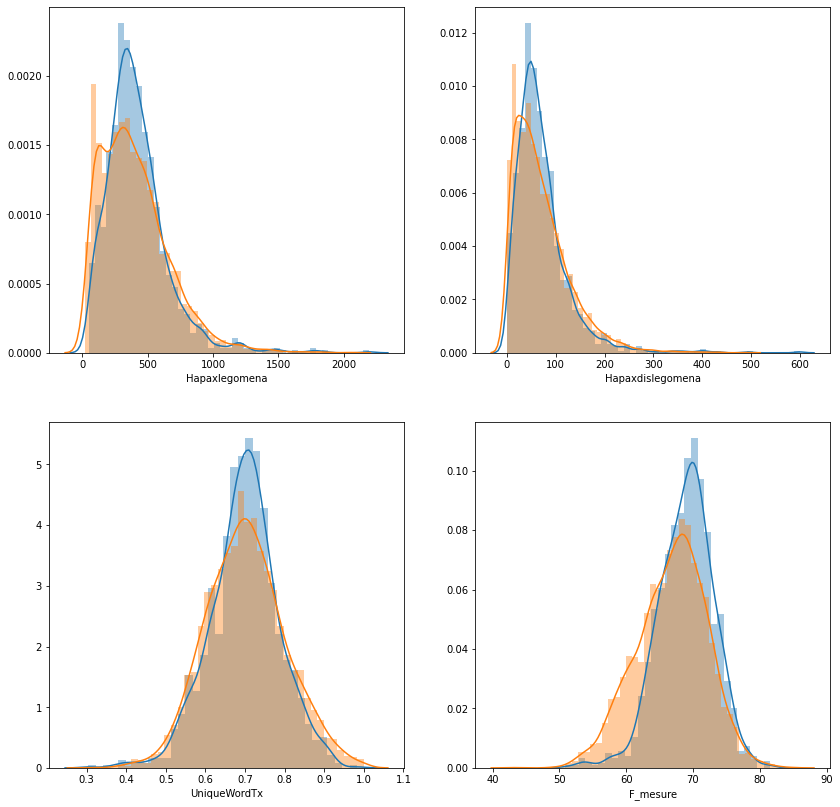

In [18]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['Hapaxlegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxlegomena'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['Hapaxdislegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxdislegomena'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['UniqueWordTx'])
sns.distplot(df[df.sexe == 1]['UniqueWordTx'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['F_mesure'])
sns.distplot(df[df.sexe == 1]['F_mesure'])
plt.show()

We can clearly see that 

In [0]:
df[['NbNom_prec']]=df[['NbNom']].div(df.NbMot,axis=0)
df[['NbDet_prec']]=df[['NbDet']].div(df.NbMot,axis=0)
df[['NbAdj_prec']]=df[['NbAdj']].div(df.NbMot,axis=0)
df[['NbPron_prec','NbVerb_perc','NbAUX_perc']]=df[['NbPron','NbVerb','NbAUX']].div(df.NbMot,axis=0)

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbNom_prec'])
sns.distplot(df[df.sexe == 1]['NbNom_prec'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbAdj_prec'])
sns.distplot(df[df.sexe == 1]['NbAdj_prec'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['NbPron_prec'])
sns.distplot(df[df.sexe == 1]['NbPron_prec'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['NbVerb_perc'])
sns.distplot(df[df.sexe == 1]['NbVerb_perc'])
plt.show()



```
# `Ce texte est au format code`
```

More over, what is intresting to observe is what type of pronoum women and men use.


In [0]:
lst=[ 'NbSyllables','NbPhrases','NbMot','NbToken','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 
       'UniqueWordTx', 'RateCleanRaw','NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb',
        'NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','NbArt', 'F_mesure'
        ]
lst = lst + ['NbNom_prec','NbDet_prec','NbAdj_prec',
    'NbPron_prec','NbVerb_perc','NbAUX_perc']
df[['PronJe_perc','PronNous_perc']]=df[['PronJe','PronNous']].div(df.NbMot,axis=0)
lst = lst + ['PronJe_perc','PronNous_perc']
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['PronJe_perc'])
sns.distplot(df[df.sexe == 1]['PronJe_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['PronNous_perc'] )
sns.distplot(df[df.sexe == 1]['PronNous_perc'])
plt.show()

In [0]:
df[['NbQuest_perc','NbExcl_perc']]=df[['NbQuest','NbExcl']].div(df.NbToken,axis=0)
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbQuest_perc'])
sns.distplot(df[df.sexe == 1]['NbQuest_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbExcl_perc'])
sns.distplot(df[df.sexe == 1]['NbExcl_perc'])
plt.show()

### Sentiment extraction using [FEEL](http://advanse.lirmm.fr/feel.php) (French Expanded Emotion Lexicon)



We are using a sentiment extraction based on a french lexicon with 14 000 distinct words expressing emotions and sentiments.

Inside this lexicon we can extract the polarity of sentiment but also six different emotions : joy, fear, sad,surprise, disgust and angry. With all of this, we calculate the frequency of each emotion.

Once again this procedure is very long and that is a reason why we only use 5000 documents in our analysis (and even with this number it takes hour to compute).

In [0]:
feel = pd.read_csv('FEEL.csv',sep=';')
feel.set_index('id',inplace=True)
feel.sample(10)

In [0]:
extraction_emotion(cleanTokenLemme(df.Texte[0],cleanFast))

In [0]:
check_polarity(cleanTokenLemme(df.Texte[0],cleanFast))

In [0]:
df['CleanTokensLemme'] = df.apply(lambda row : cleanTokenLemme(row.Texte,cleanFast),axis=1)
df['PolPos'],df['PolNeg'],df['PolUnk'] = zip(*df.CleanTokensLemme.apply(check_polarity))
df['FreqJoie'],df['FreqPeur'],df['FreqSad'],df['FreqColere'],df['FreqSurprise'],df['FreqDegout'] = zip(*df.CleanTokensLemme.apply(extraction_emotion))


In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['FreqJoie'])
sns.distplot(df[df.sexe == 1]['FreqJoie'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['FreqPeur'])
sns.distplot(df[df.sexe == 1]['FreqPeur'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['FreqSad'])
sns.distplot(df[df.sexe == 1]['FreqSad'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['FreqColere'])
sns.distplot(df[df.sexe == 1]['FreqColere'])
plt.show()

### Visualize the most common word by gender

We will now draw two wordcloud, one for each sexe with our cleaned data.

In [0]:
import numpy as np
woman = np.array(Image.open("femme2.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=0.5, contour_color='black')
arr = reduce(add,df[df.sexe == 2].CleanToken.array)
corpus_f = ' '.join(arr)
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=1, contour_color='black')
arr = reduce(add,df[df.sexe == 1].CleanToken.array)
corpus_m = ' '.join(arr)
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

In [0]:
df.to_csv('minimal_df_var.csv')

## Part II : Baseline models









In order to make some modelization we only take a substract of the data.
We select two dataframes:


1.   One with balanced labelling of women and men
2.   Another unbalanced data which respect the proportion of men/women

Both have same shapes (variable and length). 
We split our dataset in two parts : 

*   Train : 80 %
*   Test : 20 %


We try different methods. The first is using features we extracted before from each document. Then, we try other methods of word embedding which are TF-IDF,   DBOW and DMM (different approch of Doc2Vec from the gensim package). Finally, we try to combine word embeding and our extracted features.

Let's first import all the material from sklearn we need. We will use six classifier : Logistic Regression,Naive Bayes, Support Vector, Decision Tree, random Forest and XGBOOST.


In [0]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Unbalanced dataset

We first work on a unbalanced dataset with 75 % of men and 25% of women (the same proportion of what we observe in the full dataframe).

In [0]:
df_deq = pd.read_csv('df_medium_deseq_var_5000.csv')

#### Feature engineering

We are just using our calculated features to predict the sexe. We will just launch our algorithm with a seed set but no other option.

In [0]:
X = df_deq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
y = df_deq.sexe.apply(lambda x : 1 if x == 2 else 0)


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

In [0]:
models  = [GaussianNB(),RandomForestClassifier(random_state=42),DecisionTreeClassifier(random_state=42),
          XGBClassifier(random_state = 42),LogisticRegression(random_state = 42,max_iter=1000),SVC(random_state = 42,probability=True)]

To evaluate our model, we create a function to extract metrics. With this help we can easely extract them and make a quantitative analysis.

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.720000,0.067265,0.254237,0.106383,0.501136
RFC,0.763333,0.089686,0.666667,0.158103,0.537458
DTC,0.667778,0.372197,0.342975,0.356989,0.568669
XGBOOST,0.747778,0.080717,0.450000,0.136882,0.524111
SVC_linear,0.738889,0.049327,0.323529,0.085603,0.507677
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Classification report :               precision    recall  f1-score   support

           0       0.79      0.77      0.78       677
           1       0.34      0.37      0.36       223

    accuracy                           0.67       900
   macro avg       0.57      0.57      0.57       900
weighted avg       0.68      0.67      0.67       900

Accuracy :  0.6677777777777778
AUC :  0.5686688171900564


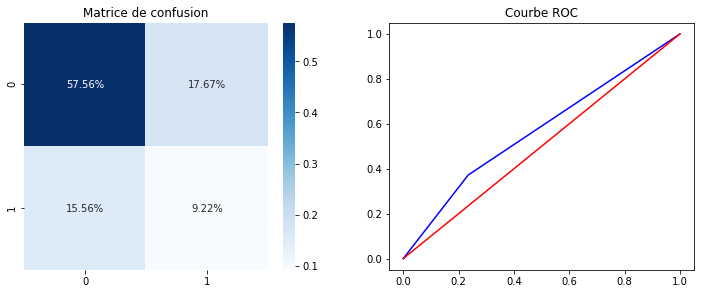

In [0]:
predictions(DecisionTreeClassifier(random_state=42),X_train,X_test,y_train,y_test)

As we can observe, we can't take the accuracy as a good metric in an unbalanced classification problem. Because 66.7 % of accuracy seems to be a good start but when you look deeper in the result with a classification report or a confusion matrix, you can see that the best clasifier for this feature is clearly not working well. We only got a 0.356 f1 score and most of the inputs are just classified as the majority class.

#### TF-IDF

This time, we use a TF-IDF on our text to see if there is an improvment compare to our feature extraction. After some test, we saw that if we use cleaned document it always end with lower prediction. So we choose to only use our raw text. 

In this approch we first use only unigram and then trigram.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop)
X = tfidfconverter.fit_transform(df_deq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.741111,0.663677,0.483660,0.559546,0.715147
RFC,0.788889,0.170404,0.883721,0.285714,0.581509
DTC,0.730000,0.457399,0.455357,0.456376,0.638596
XGBOOST,0.830000,0.394619,0.830189,0.534954,0.684015
RegLog,0.812222,0.349776,0.764706,0.480000,0.657163
SVC_rbf,0.810000,0.340807,0.760000,0.470588,0.652678


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.87      0.77      0.82       677
           1       0.48      0.66      0.56       223

    accuracy                           0.74       900
   macro avg       0.68      0.72      0.69       900
weighted avg       0.78      0.74      0.75       900

Accuracy :  0.7411111111111112
AUC :  0.7151472799411809


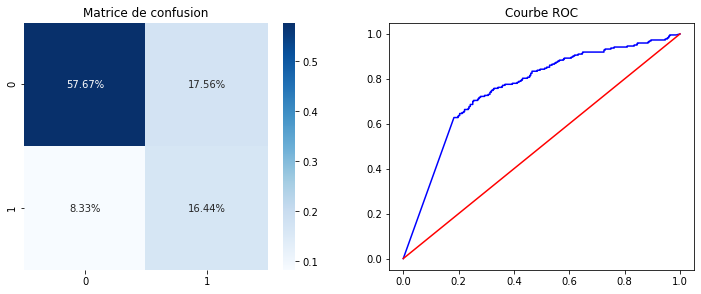

In [0]:
predictions(GaussianNB(),X_train,X_test,y_train,y_test)

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop, ngram_range=(2,3))
X = tfidfconverter.fit_transform(df_deq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.731111,0.704036,0.471471,0.564748,0.722033
RFC,0.785556,0.273543,0.663043,0.387302,0.613876
DTC,0.674444,0.309417,0.331731,0.320186,0.552050
XGBOOST,0.782222,0.161435,0.800000,0.268657,0.574071
RegLog,0.800000,0.278027,0.765432,0.407895,0.624981
SVC_rbf,0.796667,0.264574,0.756410,0.392027,0.618254


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.88      0.74      0.81       677
           1       0.47      0.70      0.56       223

    accuracy                           0.73       900
   macro avg       0.68      0.72      0.69       900
weighted avg       0.78      0.73      0.75       900

Accuracy :  0.7311111111111112
AUC :  0.7220327082684754


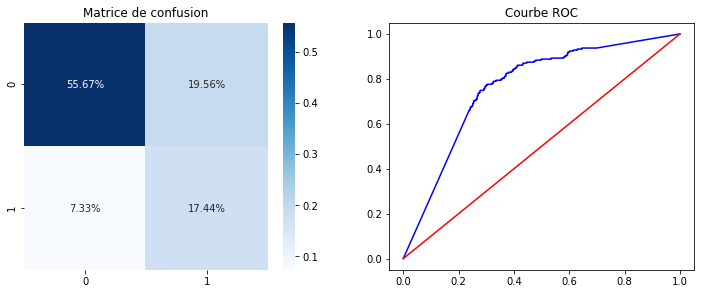

In [0]:
predictions(GaussianNB(),X_train,X_test,y_train,y_test)

The best classifier is a Naive Bayes with unigram as TF-IDF. We achieve an AUC of 0.72 and if we take a look at our confusion matrix we can see that most of the women of the corpus are correctly classified but there are too much men who are classified as women. We are improving our f1 score of more than 0.2 points. 

#### Word embeddings (TF-IDF/DBOW/DMM)

We will now use a Distributed Bag of Words (DBOW) and a Distributed Memory (DMM) with some classical initialisation parameters. 
This time we use the cleaned tokens lemme we obtain with our function.



In [0]:
train,test = train_test_split(df_deq[['CleanTokensLemme','sexe']],random_state = 42 ,test_size =0.2)
train_tagged = train.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=2)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 2931030.05it/s]


In [0]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [0]:
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_test_dbow, X_test_dbow = vec_for_learning(model_dbow, test_tagged)
y_train_dbow = pd.DataFrame(y_train_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dbow = pd.DataFrame(y_test_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
X_train_dbow =  pd.DataFrame(X_train_dbow)
X_test_dbow =  pd.DataFrame(X_test_dbow)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dbow,X_test_dbow,y_train_dbow,y_test_dbow)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.672222,0.192825,0.272152,0.225722,0.511479
RFC,0.748889,0.008969,0.285714,0.017391,0.500792
DTC,0.612222,0.251121,0.235294,0.242950,0.491144
XGBOOST,0.752222,0.008969,0.500000,0.017621,0.503007
SVC_linear,0.752222,0.000000,0.000000,0.000000,0.500000
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


The metrics are clearly droping with this method. This is clearly not a good way to classify our problem. Moreover, we can observe that for two classifiers we got 75% accuracy. Not bad ! But this is because they always predict men whatever we feed them.

Let's now try a distrubed memory model.

In [0]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=2, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 744991.83it/s]


In [0]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [0]:
y_train_dmm, X_train_dmm = vec_for_learning(model_dmm, train_tagged)
y_test_dmm, X_test_dmm = vec_for_learning(model_dmm, test_tagged)
y_train_dmm = pd.DataFrame(y_train_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dmm = pd.DataFrame(y_test_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
X_train_dmm =  pd.DataFrame(X_train_dmm)
X_test_dmm =  pd.DataFrame(X_test_dmm)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.650000,0.515695,0.357143,0.422018,0.604967
RFC,0.771111,0.107623,0.774194,0.188976,0.548642
DTC,0.634444,0.345291,0.296154,0.318841,0.537491
XGBOOST,0.770000,0.152466,0.653846,0.247273,0.562939
SVC_linear,0.764444,0.098655,0.666667,0.171875,0.541203
SVC_rbf,0.757778,0.035874,0.727273,0.068376,0.515722


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.81      0.69      0.75       677
           1       0.36      0.52      0.42       223

    accuracy                           0.65       900
   macro avg       0.59      0.60      0.59       900
weighted avg       0.70      0.65      0.67       900

Accuracy :  0.65
AUC :  0.6049671791271171


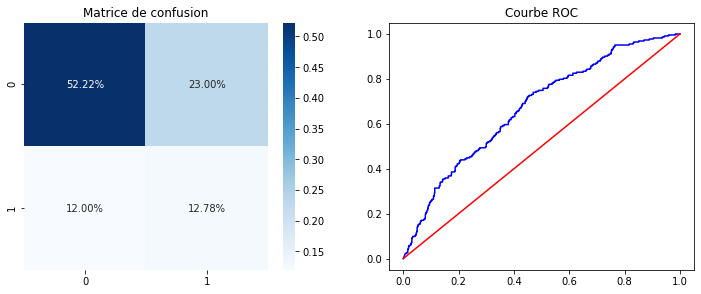

In [0]:
predictions(GaussianNB(),X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)

The results are a little bit better but their are still under our previous try with others methods. So we will not keep them and we will proceed in the next part with the TF-IDF approach plus our features.

#### Embeddings + features

The best embedding method that we used is the TF-IDF with a f1 score of 0.56. We want to see if we can improve it when using our features.


In [0]:
X_train_idf_tri,X_test_idf_tri = pd.DataFrame(X_train),pd.DataFrame(X_test)
X = df_deq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]

In [0]:
X_train,X_test=train_test_split(X,random_state=42,test_size=0.2)

In [0]:
idx = X_train.index
X_train_idf_tri = X_train_idf_tri.set_index(idx)
X_train_combine = pd.concat([X_train_idf_tri, X_train], axis=1)
idx=  X_test.index
X_test_idf_tri = X_test_idf_tri.set_index(idx)
X_test_combine = pd.concat([X_test_idf_tri, X_test], axis=1)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_combine,X_test_combine,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.740000,0.354260,0.467456,0.403061,0.610660
RFC,0.776667,0.152466,0.739130,0.252788,0.567371
DTC,0.690000,0.390135,0.378261,0.384106,0.589454
XGBOOST,0.773333,0.130045,0.743590,0.221374,0.557637
RegLog,0.741111,0.067265,0.375000,0.114068,0.515168
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.80      0.87      0.83       677
           1       0.47      0.35      0.40       223

    accuracy                           0.74       900
   macro avg       0.64      0.61      0.62       900
weighted avg       0.72      0.74      0.73       900

Accuracy :  0.74
AUC :  0.6106603254929754


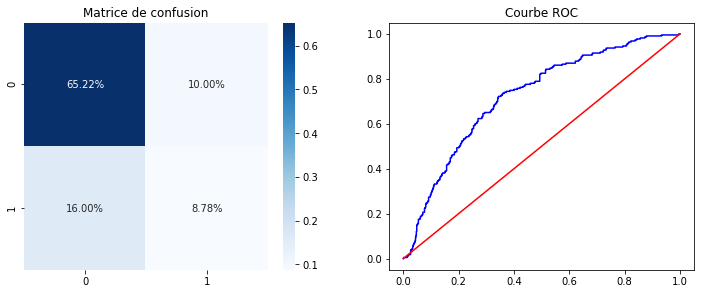

In [0]:
predictions(GaussianNB(),X_train_combine,X_test_combine,y_train,y_test)

Unfortunately, when we combine both method we are not getting any improvement on the unbalanced dataset. 

#### Conclusion on the umbalanced dataset

As we can see, the best method seem to be the TF-Idf tri-gram with a Naive Bayes model (with 0.5647 f1_score and a AUC of 0.72).
Moreover with the confusion matrix we find that the model is almost classying all women correctly.
We will now try the same approch with a balanced dataset and after that we will try to tune the best model to extract some gender marker.



### Balanced dataset

When working with unbalanced labels you have several choice to balance them in order to train models in more efficient way. We choose to down-sample the majority class in order to have 2500 documents for each gender. 

We are just doing the same previous operations but with our balanced dataset.

After that we will choose the best model, fine tune it and then try to extract some feature importance.
We will not explain anything except our best result in this part because it is same processing as previously presented


In [0]:
df_eq = pd.read_csv('df_medium_eq_var_5000.csv')

#### Feature engineering

In [0]:
X = df_eq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
y = df_eq.sexe.apply(lambda x : 1 if x == 2 else 0)


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

In [0]:
models  = [GaussianNB(),RandomForestClassifier(random_state=42),DecisionTreeClassifier(random_state=42),
          XGBClassifier(random_state = 42),LogisticRegression(random_state = 42,max_iter=1000),SVC(random_state = 42,probability=True)]
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.519,0.884,0.510983,0.647619,0.519
RFC,0.652,0.714,0.635231,0.672316,0.652
DTC,0.572,0.574,0.571713,0.572854,0.572
XGBOOST,0.653,0.748,0.628571,0.683105,0.653
RegLog,0.632,0.658,0.625475,0.641326,0.632
SVC_rbf,0.567,0.696,0.553259,0.616475,0.567


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Classification report :               precision    recall  f1-score   support

           0       0.69      0.56      0.62       500
           1       0.63      0.75      0.68       500

    accuracy                           0.65      1000
   macro avg       0.66      0.65      0.65      1000
weighted avg       0.66      0.65      0.65      1000

Accuracy :  0.653
AUC :  0.653


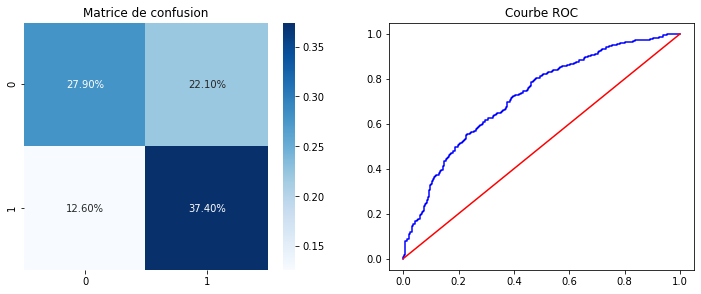

In [0]:
predictions(XGBClassifier(random_state = 42),X_train,X_test,y_train,y_test)

Our best model for our features is now a XGBOOST. The confusion matrix show that most of the women are correctly classified but too many men are classified as women. For the balanced dataset, we have a 0.68 f1 score to bit

#### Word embeddings (TF-IDF/DBOW/DMM)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop)
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.717,0.700,0.724638,0.712106,0.717
RFC,0.765,0.754,0.770961,0.762386,0.765
DTC,0.673,0.688,0.667961,0.677833,0.673
XGBOOST,0.765,0.766,0.764471,0.765235,0.765
RegLog,0.769,0.766,0.770624,0.768305,0.769
SVC_rbf,0.768,0.778,0.762745,0.770297,0.768


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
Classification report :               precision    recall  f1-score   support

           0       0.77      0.76      0.77       500
           1       0.76      0.78      0.77       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000

Accuracy :  0.768
AUC :  0.768


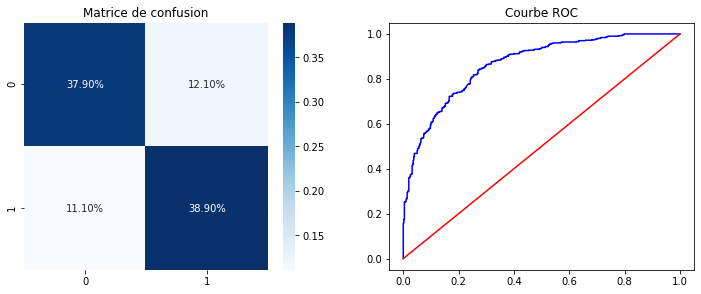

In [0]:
predictions(SVC(random_state = 42,probability=True),X_train,X_test,y_train,y_test)

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop, ngram_range=(2,3))
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.721,0.668,0.747204,0.705385,0.721
RFC,0.713,0.704,0.716904,0.710394,0.713
DTC,0.639,0.652,0.635478,0.643633,0.639
XGBOOST,0.706,0.658,0.727876,0.691176,0.706
RegLog,0.739,0.736,0.740443,0.738215,0.739
SVC_rbf,0.739,0.740,0.738523,0.739261,0.739


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
Classification report :               precision    recall  f1-score   support

           0       0.74      0.74      0.74       500
           1       0.74      0.74      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

Accuracy :  0.739
AUC :  0.739


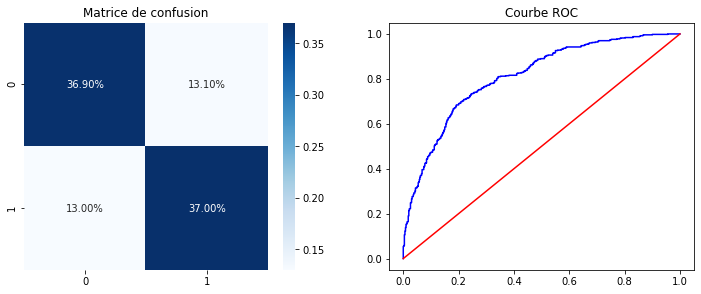

In [0]:
predictions(SVC(random_state = 42,probability=True),X_train,X_test,y_train,y_test)

In [0]:
train,test = train_test_split(df_eq[['CleanTokensLemme','sexe']],random_state = 42 ,test_size =0.2)
train_tagged = train.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=2)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_test_dbow, X_test_dbow = vec_for_learning(model_dbow, test_tagged)
y_train_dbow = pd.DataFrame(y_train_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dbow = pd.DataFrame(y_test_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
X_train_dbow =  pd.DataFrame(X_train_dbow)
X_test_dbow =  pd.DataFrame(X_test_dbow)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dbow,X_test_dbow,y_train_dbow,y_test_dbow)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.483,0.262,0.469534,0.336329,0.483
RFC,0.516,0.456,0.518182,0.485106,0.516
DTC,0.483,0.490,0.483235,0.486594,0.483
XGBOOST,0.501,0.488,0.501027,0.494428,0.501
RegLog,0.486,0.516,0.486792,0.500971,0.486
SVC_rbf,0.482,0.662,0.486765,0.561017,0.482


In [0]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=2, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [0]:
y_train_dmm, X_train_dmm = vec_for_learning(model_dmm, train_tagged)
y_test_dmm, X_test_dmm = vec_for_learning(model_dmm, test_tagged)
y_train_dmm = pd.DataFrame(y_train_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dmm = pd.DataFrame(y_test_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)

X_train_dmm =  pd.DataFrame(X_train_dmm)
X_test_dmm =  pd.DataFrame(X_test_dmm)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.600,0.502,0.624378,0.556541,0.600
RFC,0.655,0.620,0.666667,0.642487,0.655
DTC,0.561,0.572,0.559687,0.565776,0.561
XGBOOST,0.645,0.612,0.655246,0.632885,0.645
RegLog,0.644,0.604,0.656522,0.629167,0.644
SVC_rbf,0.668,0.616,0.687500,0.649789,0.668


The best embedding method is once again the TF-IDF with now a SVC. We got a improvment of 0.03 points in our f1 score.

#### Embeddings + features

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop)
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train_idf,X_test_idf,y_train_idf,y_test_idf = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
X_train_idf,X_test_idf = pd.DataFrame(X_train_idf),pd.DataFrame(X_test_idf)
X = df_eq[['NbToken', 'NbSyllables', 'NbMot', 'NbPhrases','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 'UniqueWordTx', 'RateCleanRaw',
       'NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','PronJe', 'PronNous', 'NbPres', 'NbPast', 'NbFut', 'NbImp', 'NbQuest',
       'NbExcl', 'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
X_train,X_test=train_test_split(X,random_state=42,test_size=0.2)

In [0]:
idx = X_train.index
X_train_idf = X_train_idf.set_index(idx)
X_train_combine = pd.concat([X_train_idf, X_train], axis=1)
idx=  X_test.index
X_test_idf = X_test_idf.set_index(idx)
X_test_combine = pd.concat([X_test_idf, X_test], axis=1)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_combine,X_test_combine,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.560,0.900,0.535714,0.671642,0.560
RFC,0.771,0.758,0.778234,0.767984,0.771
DTC,0.681,0.704,0.673040,0.688172,0.681
XGBOOST,0.764,0.790,0.750951,0.769981,0.764
RegLog,0.639,0.670,0.630885,0.649855,0.639
SVC_rbf,0.563,0.696,0.549763,0.614298,0.563


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Classification report :               precision    recall  f1-score   support

           0       0.78      0.74      0.76       500
           1       0.75      0.79      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

Accuracy :  0.764
AUC :  0.764


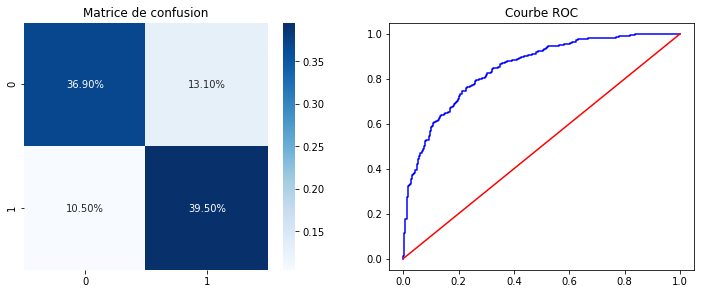

In [0]:
predictions(XGBClassifier(random_state = 42),X_train_combine,X_test_combine,y_train,y_test)

#### Conclusion on the balanced dataset

We obtain the best results when using our homemade features and a non-optimised  classical TF-IDF. We obtain a f1_score of 0.77. We increased our results by 0.2 compared to the best classifier for the unbalanced dataset. 

We will now tune the TF IDF.


### Tunning the best classifier

Our best classifier seems to be a XGBOOST with featured variables plus a TF-IDF.

We will make a classical GridSearch CV tune our TF-IDF and then run the XGBOOST on this optimal TF-IDF

#### GridSearchCV

First, we tune our TF-IDF

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [0]:
X = df_eq['Texte']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)
xgb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('xgb', XGBClassifier(random_state = 42))
])
xgb_pipe.fit(X_train, y_train)
tf_params = {
 "tvec__max_features":[100, 500,1000,1500,2000,2500,3000,3500,4000,5000],
 "tvec__ngram_range": [(1, 1), (1, 2), (2, 2),(3,3),(4,4)],
 "tvec__stop_words": [fr_stop],
 "tvec__max_df":[0.7],
 "tvec__min_df":[0.2,0.3,0.1],
 "tvec__norm":['l2']}
xgb_gs = GridSearchCV(xgb_pipe, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = 1)
xgb_gs.fit(X_train, y_train)

In [0]:
xgb_gs.best_params_

After a lot of computation time, we finally come with an optimal TF-IDF with 1000 features and a range (1,2). We are now launching our classifier to observe the best results.
#### Results of the tuned classifier

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1000, min_df=0.1, max_df=0.7, stop_words=fr_stop,ngram_range= (1, 2))
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train_idf,X_test_idf,y_train_idf,y_test_idf = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
X_train_idf,X_test_idf = pd.DataFrame(X_train_idf),pd.DataFrame(X_test_idf)
X = df_eq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
X_train,X_test=train_test_split(X,random_state=42,test_size=0.2)
idx = X_train.index
X_train_idf = X_train_idf.set_index(idx)
X_train_combine = pd.concat([X_train_idf, X_train], axis=1)
idx=  X_test.index
X_test_idf = X_test_idf.set_index(idx)
X_test_combine = pd.concat([X_test_idf, X_test], axis=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Classification report :               precision    recall  f1-score   support

           0       0.79      0.75      0.77       500
           1       0.76      0.80      0.78       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

Accuracy :  0.776
AUC :  0.776


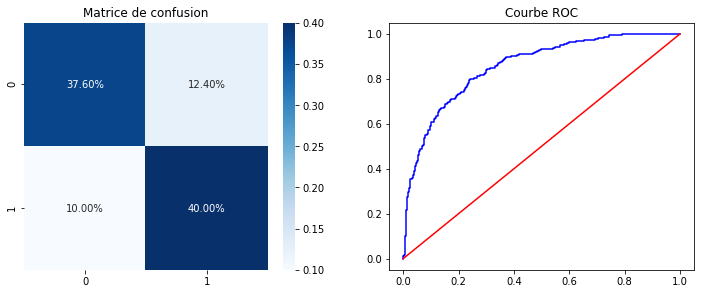

In [0]:
predictions(XGBClassifier(random_state = 42),X_train_combine,X_test_combine,y_train,y_test)

Finaly we obtain a model with an AUC of 0.776 which results in a pretty good ROC curve. Plus, we obtain now an accuracy of 77.6% which is beyond our first assumption which was a rate between 60% and 70%. 
Concerning our f1 score we are getting a final score of 0.78 which is closer than ever to 1.

Compare to our non tuned TF-IDF model we obtain a gain of 1% of accuracy. The model has just improved a bit in the classification of both class.

There is still 20% of our test set which is not correctly classified. After looking at feature importance we will try to understand briefly why they are incorrectly classified.

#### Going deeper in results

Let's make a quick qualitative analysis and try to understand what we can extract from these results. 
First, we are trying to extract the most important score on the TF-IDF for each gender. 

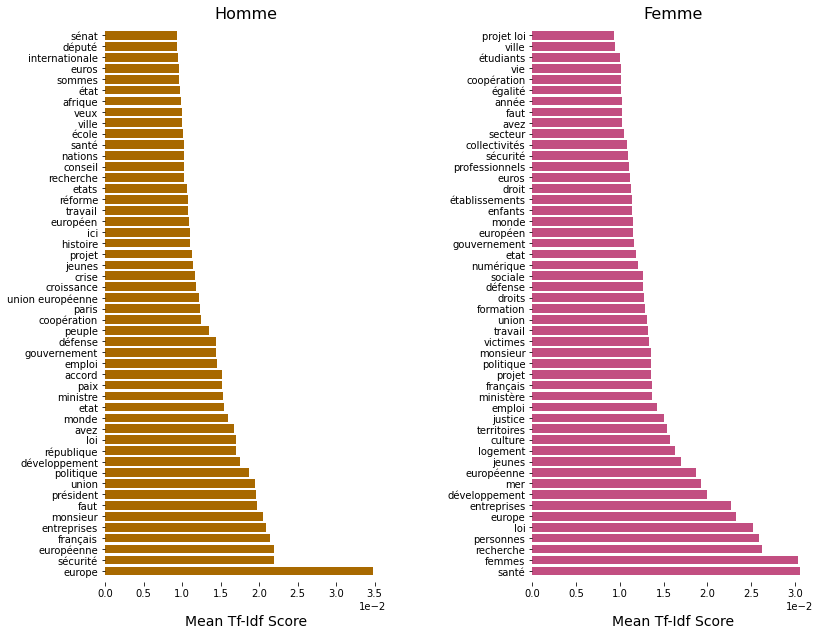

In [0]:
features=tfidfconverter.get_feature_names()
plot_tfidf_classfeats_h(top_feats_by_class(X_train_idf, y_train_idf, features, min_tfidf=0.1, top_n=50))

We observe that some words do not have the same importance. For instance, women display a high mean TF-IDF score for 'santé' when 'europe' is the highiest for men(5th in the women list). Moreover, we observe that some thematics are dividing gender. Men most important mean TF-IDF scores concern Europe, republic, economics or defence. While women most important mean TF-IDF scores are society, people, justice and familly.

This is certainly correlated with women positions at the government.

In [0]:
model = XGBClassifier(random_state = 42)
X_train_combine.columns=features+list(X.columns)
model.fit(X_train_combine,y_train_idf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

We want now to see if our homemade features have an importance in the model. 

In [0]:
df_imp = pd.DataFrame(model.feature_importances_[1000:],columns=['Imp']).set_index(X.columns)
df_imp.sort_values('Imp',ascending=False,inplace=True)

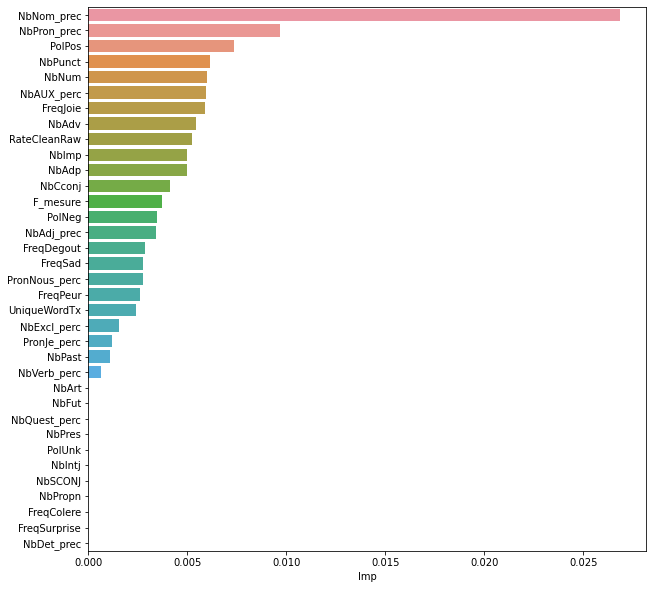

In [0]:
plt.figure(figsize=(10,10))
sns.barplot(x = df_imp.Imp,y = df_imp.index)

We can observe that some of the variables are clearly pennalized by the XGBOOST l2 penalty. For example, variables such as the number of articles or the number of questions marks are clearly not helping to dicriminize gender. On the other hand, the number of pronoum or the positive polarity of the text is helping to classify gender. We retrieve a result that has been observed in previous studies.

In [0]:
from xgboost import plot_importance

<Figure size 720x720 with 0 Axes>

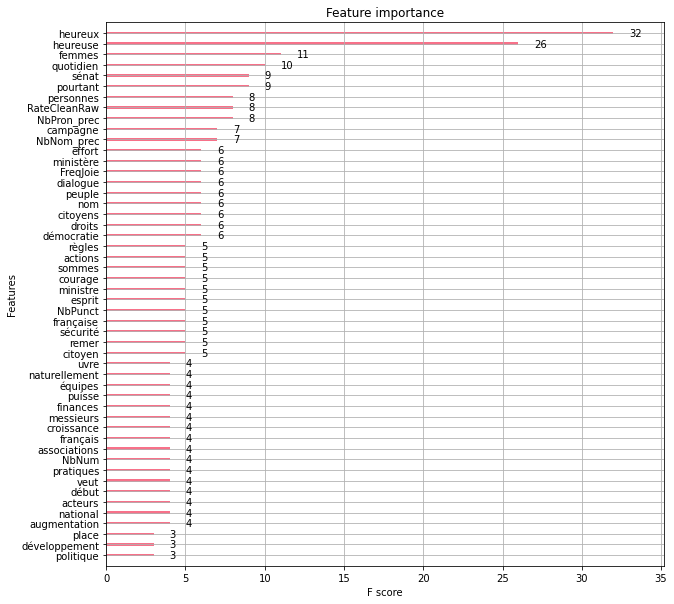

In [0]:
plt.figure(figsize=(10,10))
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(10, 10)

This time, we are observing the top 50 of our feature importance. Here we can see that some words have a big score. For example, the two most important feature are 'heureux' and 'heureuse'. 

References 

https://bib.irb.hr/datoteka/861053.Gender_differences_in_the_personal_pronouns_usage_of_the_corpus_of_congressional_speeches.pdf

https://www.researchgate.net/publication/253291274_Gender_Differences_in_Language_Use_An_Analysis_of_14000_Text_Samples/link/571e3c1b08aeaced7889ddce/download
https://buhrmann.github.io/tfidf-analysis.html
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4